In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, GRU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import ADASYN
from sklearn.decomposition import PCA

In [ ]:
def preprocess_data():
    # Load the dataset
    df = pd.read_csv('/content/heart_disease_health_indicators.csv')

    # Split dataset into features (X) and target (y)
    X = df.drop(columns=['HeartDiseaseorAttack'])
    y = df['HeartDiseaseorAttack']

    # Perform ADASYN oversampling to balance the dataset
    adasyn = ADASYN()
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    # Split into training and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA for dimensionality reduction, keeping 98% variance
    pca = PCA(n_components=0.98)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Reshape for CNN and GRU input (3D for Conv1D and GRU layers)
    X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
    X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

    return X_train_pca, X_test_pca, y_train, y_test

In [ ]:
# -------------------- Model Definition Block --------------------
def create_lenet_model(input_shape):
    """Creates and returns a more complex CNN-based model (LeNet)"""
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))  # Increased filters to 128
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv1D(256, kernel_size=3, activation='relu'))  # Increased filters to 256
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv1D(512, kernel_size=3, activation='relu', padding='same'))  # Added padding='same'
    #model.add(Conv1D(512, kernel_size=1, activation='relu'))  # Increased filters to 512
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))  # Increased dense units to 512
    model.add(Dropout(0.5))  # Adjusted dropout to 0.5 to combat overfitting while retaining more info
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    return model

def create_gru_model(input_shape):
    """Creates and returns a more complex GRU-based model"""
    model = Sequential()
    model.add(GRU(256, return_sequences=True, input_shape=input_shape))  # Increased GRU units
    model.add(GRU(128, return_sequences=False))
    model.add(Dense(256, activation='relu'))  # Increased dense units
    model.add(Dropout(0.5))  # Adjusted dropout for GRU
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_enscvdd_net(input_shape):
    """Creates and returns the enhanced EnsCVDD-Net architecture"""
    lenet_model = create_lenet_model(input_shape)
    gru_model = create_gru_model(input_shape)

    # Combine LeNet and GRU outputs
    dummy_input = tf.keras.Input(shape=input_shape)
    lenet_output = lenet_model(dummy_input)
    gru_output = gru_model(dummy_input)
    combined_input = tf.keras.layers.concatenate([lenet_output, gru_output])

    # Final dense layers for prediction
    x = Dense(256, activation='relu')(combined_input)  # Increased units in combined layer
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=dummy_input, outputs=output)
    return model

def create_blcvdd_net(input_shape, X_train, y_train):
    """Creates and trains the enhanced BlCVDD-Net"""
    lenet_model = create_lenet_model(input_shape)
    gru_model = create_gru_model(input_shape)

    lenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for more stable training
                        loss='binary_crossentropy', metrics=['accuracy'])
    gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='binary_crossentropy', metrics=['accuracy'])

    # Train LeNet and GRU models
    lenet_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)  # Increased epochs
    gru_model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

    # Get predictions from the base models
    lenet_pred = lenet_model.predict(X_train)
    gru_pred = gru_model.predict(X_train)

    # Combine predictions from both models
    combined_preds = np.hstack([lenet_pred, gru_pred])

    # Create MLP meta-learner
    mlp_model = Sequential()
    mlp_model.add(Dense(256, activation='relu', input_shape=(combined_preds.shape[1],)))  # Increased units
    mlp_model.add(Dropout(0.5))
    mlp_model.add(Dense(1, activation='sigmoid'))

    return mlp_model, combined_preds, lenet_model, gru_model


In [ ]:


# -------------------- Training and Evaluation Block --------------------

def compile_and_train_model(model, X_train, y_train, X_test, y_test, name):
    """Compiles, trains, evaluates the model and plots the confusion matrix."""
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
                  loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Increased patience
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Train the model with validation
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2,  # Increased epochs to 50
                        callbacks=[early_stopping, reduce_lr], verbose=1)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    # Predictions and metrics
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    # Print metrics
    print(f'{name} - Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, '
          f'Test Recall: {recall:.4f}, Test F1-Score: {f1:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return history

def plot_training_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - accuracy: 0.7674 - loss: 0.5250 - val_accuracy: 0.8300 - val_loss: 0.3938 - learning_rate: 1.0000e-04
Epoch 2/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - accuracy: 0.8256 - loss: 0.4002 - val_accuracy: 0.8385 - val_loss: 0.3680 - learning_rate: 1.0000e-04
Epoch 3/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.8378 - loss: 0.3716 - val_accuracy: 0.8541 - val_loss: 0.3336 - learning_rate: 1.0000e-04
Epoch 4/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.8472 - loss: 0.3430 - val_accuracy: 0.8618 - val_loss: 0.3128 - learning_rate: 1.0000e-04
Epoch 5/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8549 - loss: 0.3252 - val_accuracy: 0.8625 - val_loss: 0.3048 - learning_rate: 1.0000e-04
Epoch 6/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.8582 - loss: 0.3159 - val_accuracy: 0.8646 - val_loss: 0.3005 - learning_rate: 1.0000e-04
Epoch 7/30
4606/4606 ━━━━━━━━━━━━━━━━━━━

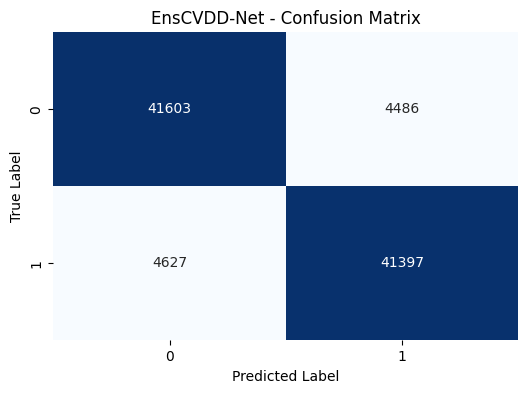

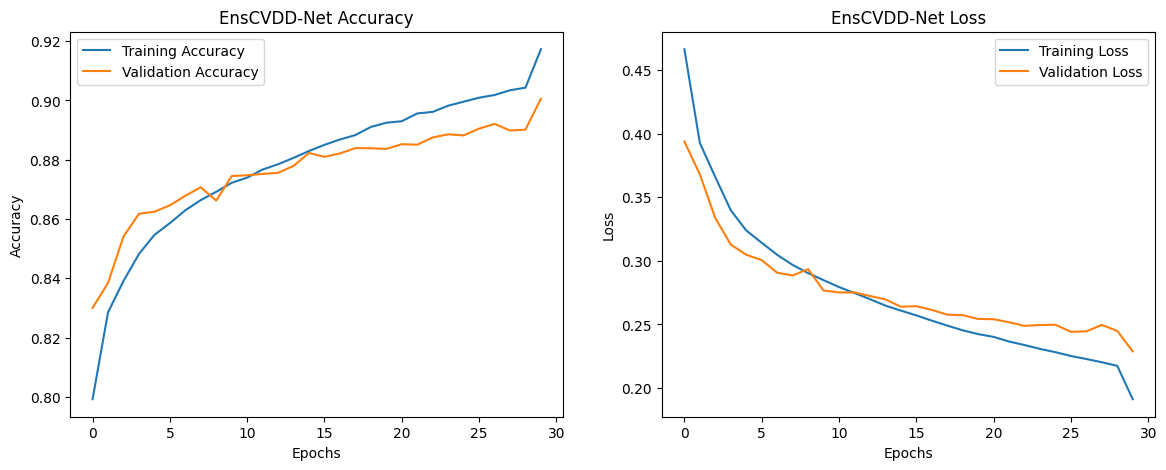

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7885 - loss: 0.4604
Epoch 2/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8368 - loss: 0.3526
Epoch 3/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8502 - loss: 0.3250
Epoch 4/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8576 - loss: 0.3086
Epoch 5/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8635 - loss: 0.2966
Epoch 6/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8676 - loss: 0.2884
Epoch 7/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8699 - loss: 0.2807
Epoch 8/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8734 - loss: 0.2751
Epoch 9/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8749 - loss: 0.2730
Epoch 10/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8777 - loss: 0.2658
Epoch 11/30
5758/5758 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8823 - loss: 0.2585
Epoch 12/30
5758/57

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4606/4606 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8617 - loss: 0.3844 - val_accuracy: 0.9279 - val_loss: 0.1741
Epoch 2/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9288 - loss: 0.1747 - val_accuracy: 0.9285 - val_loss: 0.1714
Epoch 3/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9283 - loss: 0.1741 - val_accuracy: 0.9285 - val_loss: 0.1704
Epoch 4/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9283 - loss: 0.1734 - val_accuracy: 0.9284 - val_loss: 0.1699
Epoch 5/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9281 - loss: 0.1735 - val_accuracy: 0.9287 - val_loss: 0.1695
Epoch 6/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9290 - loss: 0.1717 - val_accuracy: 0.9287 - val_loss: 0.1691
Epoch 7/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9286 - loss: 0.1729 - val_accuracy: 0.9287 - val_loss: 0.1687
Epoch 8/30
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9289 - loss: 0.1707 - val

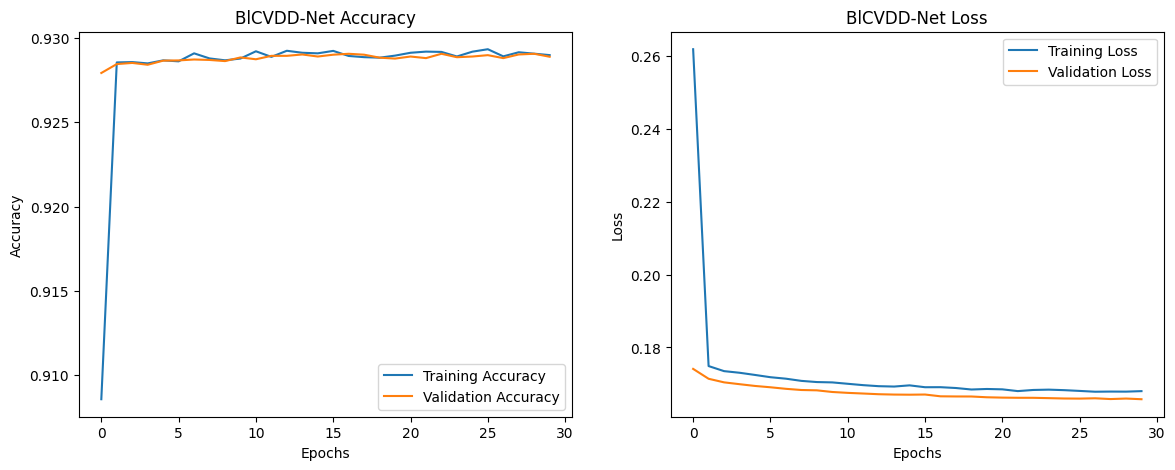

2879/2879 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
BlCVDD-Net Accuracy: 0.9025, Precision: 0.9098, Recall: 0.8933, F1: 0.9015


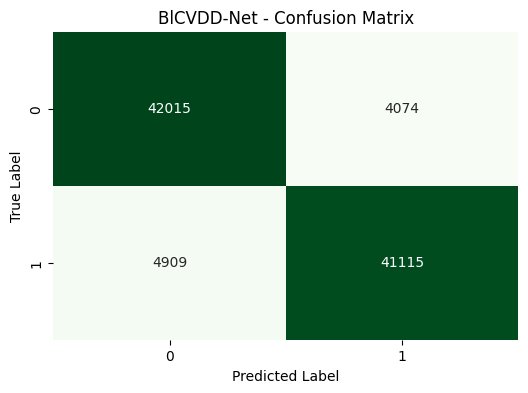

In [ ]:
# -------------------- Main Code --------------------

if __name__ == '__main__':
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data()

    # Train and evaluate EnsCVDD-Net
    enscvdd_model = create_enscvdd_net((X_train.shape[1], 1))
    enscvdd_history = compile_and_train_model(enscvdd_model, X_train, y_train, X_test, y_test, "EnsCVDD-Net")

    # Plot training history for EnsCVDD-Net
    plot_training_history(enscvdd_history, "EnsCVDD-Net")

    # Train and evaluate BlCVDD-Net
    blcvdd_model, combined_preds_train, lenet_model, gru_model = create_blcvdd_net((X_train.shape[1], 1), X_train, y_train)

    # Compile and train MLP meta-learner
    blcvdd_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    blcvdd_history = blcvdd_model.fit(combined_preds_train, y_train, epochs=30, batch_size=64, validation_split=0.2, verbose=1)

    # Plot training history for BlCVDD-Net
    plot_training_history(blcvdd_history, "BlCVDD-Net")

    # Prepare test predictions for BlCVDD-Net
    lenet_pred_test = lenet_model.predict(X_test)
    gru_pred_test = gru_model.predict(X_test)
    combined_preds_test = np.hstack([lenet_pred_test, gru_pred_test])

    # Make final predictions with meta-learner
    blcvdd_predictions = blcvdd_model.predict(combined_preds_test)
    blcvdd_predictions = (blcvdd_predictions > 0.5).astype(int)

    # Compute confusion matrix for BlCVDD-Net
    cm_blcvdd = confusion_matrix(y_test, blcvdd_predictions)

    # Calculate metrics for BlCVDD-Net
    blcvdd_accuracy = accuracy_score(y_test, blcvdd_predictions)
    blcvdd_precision = precision_score(y_test, blcvdd_predictions)
    blcvdd_recall = recall_score(y_test, blcvdd_predictions)
    blcvdd_f1 = f1_score(y_test, blcvdd_predictions)

    # Print metrics for BlCVDD-Net
    print(f'BlCVDD-Net Accuracy: {blcvdd_accuracy:.4f}, Precision: {blcvdd_precision:.4f}, '
          f'Recall: {blcvdd_recall:.4f}, F1: {blcvdd_f1:.4f}')

    # Plot confusion matrix for BlCVDD-Net
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_blcvdd, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('BlCVDD-Net - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()